In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [9]:
df = pd.read_csv('./training_set_VU_DM.csv')

In [10]:
df = df.drop(['position', 'gross_bookings_usd'], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 52 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  price_usd                    float64
 15  promotion_flag               int64  
 16  srch_destination_id          int64  
 17  srch_length_of_stay          int64  
 18  srch_booking_window          int64  
 19  

In [12]:
print(df.isnull().sum())

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance      1607782
random_bool              

In [13]:
def season_booking(row):
    month = row['date_booking'].month
    day = row['date_booking'].day

    if (month == 3 and day >= 21) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'spring'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 21):
        return 'summer'
    elif (month == 9 and day >= 21) or (month == 10) or (month == 11) or (month == 12 and day < 21):
        return 'autumn'
    else:
        return 'winter'

In [14]:
#Add column with day of the week
df['date_time'] = pd.to_datetime(df['date_time'])
df['weekday'] = df['date_time'].dt.dayofweek
#df['weekday_name'] = df['date_time'].dt.day_name()
df['part_of_day'] = pd.cut(df['date_time'].dt.hour,[0,6,12,18,24],labels=['night','morning','afternoon','evening'],include_lowest=True)

#Add column last minute whenever it is booked within 2 weeks upfront
df['last_minute'] = [1 if x <= 14 else 0 for x in df['srch_booking_window']]

df['date_booking'] = df['date_time'] + pd.to_timedelta(df['srch_booking_window'], unit='d')

#Fill NaN values from Gross_bookings_usd with 0
#df['gross_bookings_usd'] = df['gross_bookings_usd'].fillna(0)

#If the price is outside the lower and upper quantile, replace it with the mean of the price of that hotel
df['price_usd'] = np.where((df['price_usd'] < df['price_usd'].quantile(0.001)) | (df['price_usd'] > df['price_usd'].quantile(0.999)), df.groupby('prop_country_id')['price_usd'].transform('mean'), df['price_usd'])

In [15]:
df['date_booking'] = df['date_time'] + pd.to_timedelta(df['srch_booking_window'], unit='d')
df['season_booking'] = df.apply(season_booking, axis=1)
df.drop(['date_booking'], axis=1, inplace=True)

In [16]:
df['prop_review_score'] = df['prop_review_score'].fillna('bfill')

In [17]:
# Combining the competitors rate (based on the price), takes the rate only if all competitors have the same rate
# Not correct but this is what the 'highest' is --> lowest price, same price or highest price compared to all competitors
df['comp_rate'] = [1 if all(x == 1 for x in row) else 0 if all(x == 0 for x in row) else -1 for row in df[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']].values]
columns = ['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']
for column in columns:
    df[column] = df[column] + 1
    df['comp_rate'] = df.groupby('prop_id')[column].transform('mean')
columns2 = ['comp1_inv', 'comp2_inv', 'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 'comp8_inv']
for column in columns2:
    df[column] = df[column] + 1
    df['comp_inv'] = df.groupby('prop_id')[column].transform('mean')
columns2 = ['comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']
for column in columns2:
    df['comp_rate_percent_diff'] = df.groupby('prop_id')[column].transform('mean')

In [18]:
print(df.isnull().sum())

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4696764
visitor_hist_adr_usd           4695642
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                    0
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1087936
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4631332
orig_destination_distance      1601639
random_bool              

In [19]:
# Correlation matrix, skip if only data cleaning is needded
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ValueError: could not convert string to float: 'morning'

In [ ]:
df = df.dropna(axis=1, how="any")

In [ ]:
#df['click_history'] = df.groupby('srch_id')['click_bool'].transform(lambda x: x.cumsum().shift())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4948429 entries, 0 to 4958346
Data columns (total 29 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   srch_id                      int64         
 1   date_time                    datetime64[ns]
 2   site_id                      int64         
 3   visitor_location_country_id  int64         
 4   prop_country_id              int64         
 5   prop_id                      int64         
 6   prop_starrating              int64         
 7   prop_review_score            object        
 8   prop_brand_bool              int64         
 9   prop_location_score1         float64       
 10  prop_log_historical_price    float64       
 11  price_usd                    float64       
 12  promotion_flag               int64         
 13  srch_destination_id          int64         
 14  srch_length_of_stay          int64         
 15  srch_booking_window          int64         
 16  

In [ ]:
print(df.isnull().sum())

srch_id                        0
date_time                      0
site_id                        0
visitor_location_country_id    0
prop_country_id                0
prop_id                        0
prop_starrating                0
prop_review_score              0
prop_brand_bool                0
prop_location_score1           0
prop_log_historical_price      0
price_usd                      0
promotion_flag                 0
srch_destination_id            0
srch_length_of_stay            0
srch_booking_window            0
srch_adults_count              0
srch_children_count            0
srch_room_count                0
srch_saturday_night_bool       0
random_bool                    0
click_bool                     0
booking_bool                   0
weekday                        0
weekday_name                   0
part_of_day                    0
last_minute                    0
comp_rate                      0
comp_inv                       0
dtype: int64


/var/folders/9b/61q25wrd79ndg1_s2mk4r5wm0000gn/T/ipykernel_65974/1186595043.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<AxesSubplot: >

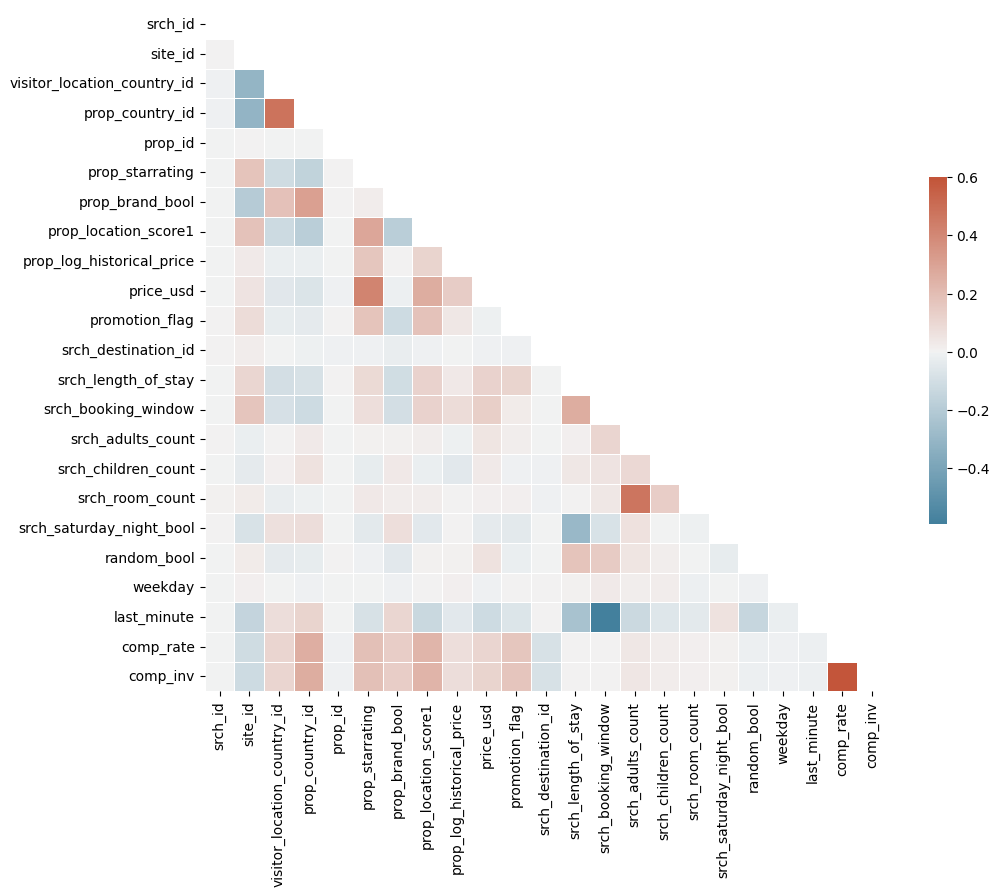

In [ ]:
# Correlation matrix, skip if only data cleaning is needded
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#normalized_df=(df-df.min())/(df.max()-df.min())

In [ ]:
df.to_csv('Data/clean_data.csv')

OSError: [Errno 28] No space left on device

## PCA

In [ ]:
import sklearn.decomposition as skd

In [ ]:
pca = skd.PCA(n_components=17)
df_pca = pca.fit_transform(normalized_df)